In [3]:
%load_ext autoreload
%autoreload 2

# Import libraries and load data

Input size is (1, 28, 28)


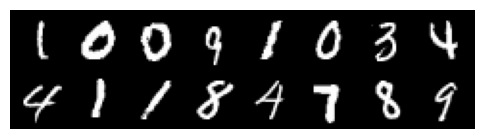

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
data = datasets.MNIST(root='./data', download=True, transform=transform)
img_shape = (data[1][0].size(0), data[1][0].size(1), data[1][0].size(2))
print(f'Input size is {img_shape}')

# Prepare dataloader for training
batch_size = 256
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Build CGAN

In [4]:
from cGAN_pytorch import Generator, Discriminator, Train

dim_latent = 100
num_class = 10
lr = 0.001
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

# Initialize generator and discriminator
G = Generator(img_shape=img_shape, num_class=num_class,
              dim_latent=dim_latent, g_dims=[128, 256, 512, 1024]).to(device)
D = Discriminator(img_shape=img_shape, num_class=num_class, d_dims=[512, 256]).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


# Training

In [5]:

Train(epoch=50, dataloader=dataloader, device=device, G=G, D=D,
      optimizer_G=optimizer_G, optimizer_D=optimizer_D)

# Save trained model if needed
torch.save(G, './CGAN_G.pt')
torch.save(D, './CGAN_D.pt')

# Load trained model if needed
G = torch.load('./CGAN_G.pt')
D = torch.load('./CGAN_D.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 / D loss: 1.0390 / G loss: 1.9388
Epoch 10 / D loss: 1.1036 / G loss: 1.1765
Epoch 15 / D loss: 1.1459 / G loss: 1.0571
Epoch 20 / D loss: 1.1800 / G loss: 1.0104
Epoch 25 / D loss: 1.2803 / G loss: 0.8452
Epoch 30 / D loss: 1.2584 / G loss: 0.8076
Epoch 35 / D loss: 1.2805 / G loss: 1.2239
Epoch 40 / D loss: 1.2657 / G loss: 0.8499
Epoch 45 / D loss: 1.2283 / G loss: 0.7316
Epoch 50 / D loss: 1.2142 / G loss: 1.1002


# Examples of Generated Images

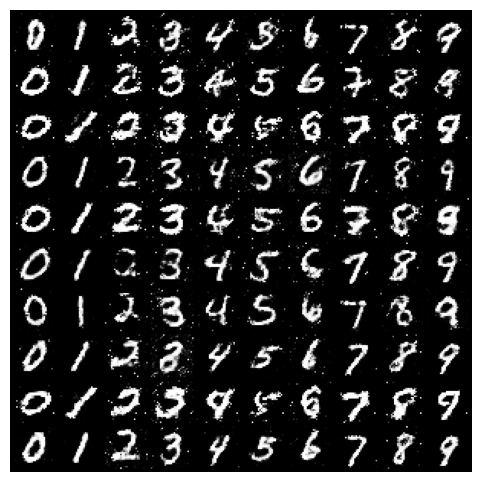

In [6]:
num_sample = num_class ** 2
G.eval()
z = torch.zeros(num_sample, dim_latent).to(device)

# Fix noise z to generate conditioned result
for i in range(num_class):
    z[i * num_class] = torch.rand(1, dim_latent)
    for j in range(1, num_class):
        z[i * num_class + j] = z[i * num_class]

temp = torch.zeros(num_class, 1)
for i in range(num_class):
    temp[i, 0] = i

temp_y = torch.zeros(num_sample, 1)
for i in range(num_class):
    temp_y[i * num_class: (i + 1) * num_class] = temp

labels = torch.zeros(num_sample, num_class).scatter_(1, temp_y.type(torch.LongTensor), 1).to(device)

fig = plt.figure(figsize=(6, 6))
fake = G(z, labels).detach().cpu()
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()